## **Text Classification with Dimensionality Reduction**  
### *Amazon Polarity Dataset (5000-row balanced subset)*
#### *Team Members:*
   - Sabrina Ronnie George Karippat - 8991911
   - Jose George                    - 
   - Aiswarya Thekkuveettil         - 

This notebook implements the full workflow for our final NLP project:
   - Load and prepare the Amazon Polarity dataset  
   - Create a balanced **5000-row subset** (2500 positive, 2500 negative)  
   - Shared preprocessing used across all models (lowercasing, train/test split, TF-IDF)  
   - **Model 1:** TF-IDF + Naive Bayes (Baseline)  
   - **Model 2:** TF-IDF → SVD → Logistic Regression  
   - **Model 3:** TF-IDF → PCA → Logistic Regression  
   - Evaluation with confusion matrices and performance metrics  
   - Final comparison of all three models  

The next cell imports all necessary libraries and defines shared configuration constants used by the entire team.

### **Setup: Imports and Shared Configuration**

In this section we load all required Python libraries for:
   - Data processing  
   - Machine learning models  
   - Dimensionality reduction  
   - Evaluation metrics  
   - Visualization  

We also define shared constants:
- `RANDOM_STATE = 42` for reproducibility  
- `N_COMPONENTS = 100` for both SVD and PCA (fair comparison across models)

In [13]:
# Basic data libraries
import pandas as pd
import numpy as np

# HuggingFace dataset loader
from datasets import load_dataset

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set style for plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

# Global random seed for reproducibility
RANDOM_STATE = 42

# Shared number of components for SVD and PCA (for fair comparison)
N_COMPONENTS = 100

#### **Why This Setup Matters**

By keeping all imports and global constants in one place:
   - All three models (NB, SVD+LR, PCA+LR) use the same settings  
   - The results become directly comparable  
   - Team members know exactly which variables are shared across the notebook  

### **Load the Amazon Polarity Dataset**

The Amazon Polarity dataset is a large-scale **sentiment analysis** dataset containing over **4 million Amazon customer product reviews**.  
Each review is labeled as either:
   - **1 → Positive review**
   - **0 → Negative review**

The reviews come from many product categories such as books, electronics, games, movies, clothing, and household items. Because the dataset covers a wide variety of products, the model learns **general sentiment patterns**, not product-specific vocabulary—making it ideal for text classification tasks.

In this step, we load the dataset from the HuggingFace `mteb` collection. We only load the **train split** because it already contains ~3.6 million samples, which is more than sufficient for creating our balanced 5000-row subset for training the three models later.

The next cell converts the dataset into a pandas DataFrame so that we can explore and preprocess it easily.


In [14]:
# Load Amazon Polarity dataset from HuggingFace (train split)
dataset = load_dataset("mteb/amazon_polarity", split="train")

# Convert to pandas DataFrame
df_full = pd.DataFrame(dataset)

df_full.head(), df_full.shape   # Preview the dataset

(   label                                               text label_text
 0      1  Stuning even for the non-gamer\n\nThis sound t...   positive
 1      1  The best soundtrack ever to anything.\n\nI'm r...   positive
 2      1  Amazing!\n\nThis soundtrack is my favorite mus...   positive
 3      1  Excellent Soundtrack\n\nI truly like this soun...   positive
 4      1  Remember, Pull Your Jaw Off The Floor After He...   positive,
 (3599994, 3))

#### **Dataset Loaded Successfully**

The dataset contains the following columns:
   - **label** → numeric sentiment label (0 = negative, 1 = positive)  
   - **text** → the actual review text  
   - **label_text** → descriptive version of the label ("positive" / "negative")

The shape `(3599994, 3)` confirms that the dataset has **~3.6 million reviews**, which is more than enough for sampling a balanced 5000-row subset (2500 positive + 2500 negative).

We will now keep only the `text` and `label` columns and proceed to build a balanced subset for all three models.

### **Select Only Relevant Columns**

The dataset contains several fields, but for sentiment classification we only need two of them:
   - **text** – the written review  
   - **label** – the sentiment (0 = negative, 1 = positive)

In the next step, we keep only these columns and check how many positive and negative samples exist in the full dataset. This helps confirm that the dataset is naturally balanced before we create our 5000-row subset.

In [4]:
# Keep only the text and label columns
df_full = df_full[['text', 'label']]

df_full['label'].value_counts()   # Check class distribution

label
1    1799998
0    1799996
Name: count, dtype: int64

#### **Interpretation of Class Distribution**

The output shows that the full dataset contains nearly the same number of:
   - **Positive reviews:** ~1.8 million  
   - **Negative reviews:** ~1.8 million  

This near-perfect balance means the dataset is well-suited for creating a **balanced subset** (2500 positive + 2500 negative = 5000 total) without introducing label bias. It also ensures that our later train/test split and model comparisons remain fair and meaningful.

### **Create a Balanced 5000-Row Subset**

The full Amazon Polarity dataset is very large (3.6M reviews), so we create a smaller **balanced subset** that is easier to train and compare models on.

To ensure fairness across all three models, we sample:
   - **2500 positive reviews (label = 1)**
   - **2500 negative reviews (label = 0)**

This gives us a **5000-row balanced dataset**, which prevents model bias toward either class. After sampling, we shuffle the rows and reset the index to remove ordering effects.

We also perform a quick **missing-value check** to verify data quality before moving forward with preprocessing and model training.

In [5]:
# Sample 2500 positive (label=1) and 2500 negative (label=0)
df_pos = df_full[df_full['label'] == 1].sample(2500, random_state=RANDOM_STATE)
df_neg = df_full[df_full['label'] == 0].sample(2500, random_state=RANDOM_STATE)

# Combine and shuffle to create a balanced 5000-row dataset
df_small = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

df_small['label'].value_counts(), df_small.shape   # Confirm balance and size

# Check for missing (null) values
df_small.isna().sum()

text     0
label    0
dtype: int64

#### **Subset Validation**

The subset is perfectly balanced:
   - **2500 positive reviews**
   - **2500 negative reviews**
   - Total: **5000 samples**

This ensures that our models are not influenced by class imbalance.

The missing-value check confirms:
   - **0 missing text entries**
   - **0 missing labels**

Since the dataset is clean, no rows need to be dropped. We can now safely proceed with preprocessing, train/test splitting, and TF-IDF feature extraction.

### **Save the Balanced 5000-Row Dataset**

To ensure all team members work with the **exact same data**, we save the balanced 5000-row subset as a CSV file inside the project’s `data/` folder.

This allows Models 1, 2, and 3 to:
   - Load the same input dataset  
   - Use the same preprocessing steps  
   - Produce results that are directly comparable  

Storing the subset also prevents re-downloading or re-sampling the large HuggingFace dataset every time the notebook is run.

In [6]:
# Save the 5000-row subset so the whole team uses the same file
df_small.to_csv("../data/amazon_polarity_5000.csv", index=False)

#### **Dataset Saved Successfully**

The balanced subset has been saved as:
   
       ../data/amazon_polarity_5000.csv

This file now serves as the **standard input dataset** for the entire group.

### **Visualize Class Distribution in the 5000-Row Subset**

Before training any model, it is important to confirm that the sampled dataset is truly **balanced**. A balanced dataset ensures that models do not become biased toward predicting one class more often than the other.

The bar chart below shows the number of positive and negative reviews in our 5000-row subset (2500 each). This balanced class distribution helps create a fair evaluation environment for all three models (Naive Bayes, SVD + LR, PCA + LR).

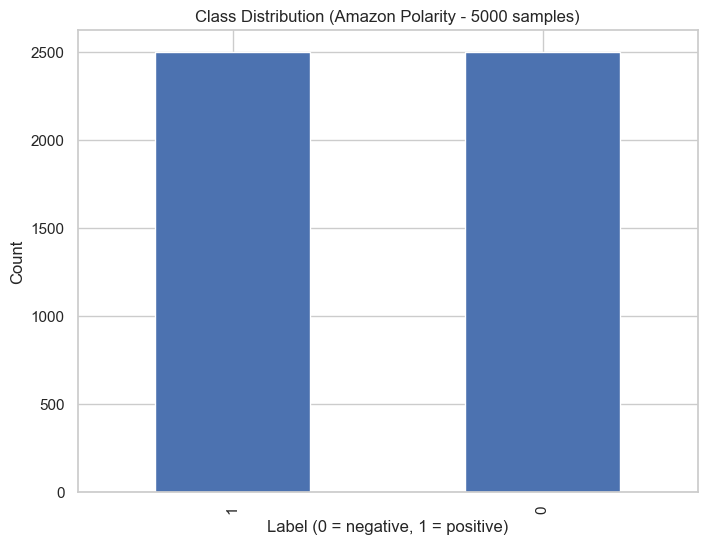

In [7]:
# Visualize the number of positive vs negative samples
df_small['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution (Amazon Polarity - 5000 samples)")
plt.xlabel("Label (0 = negative, 1 = positive)")
plt.ylabel("Count")
plt.show()

#### **Interpretation of the Class Distribution Plot**

The visualization confirms that:
   - **2500 reviews are positive (label = 1)**
   - **2500 reviews are negative (label = 0)**

This perfect balance eliminates class imbalance issues, meaning:
   - No class weighting is needed  
   - Accuracy remains a reliable metric  
   - All models will be able to learn both positive and negative sentiment equally  

With this verification complete, we can proceed to preprocessing and feature extraction (TF-IDF).

In [8]:
# Convert all text to lowercase to reduce noise
df_small['text'] = df_small['text'].str.lower()

df_small['text'].head()   # Preview cleaned text

0    valient effort, low budget\n\ni really enjoyed...
1    o my gosh dont bother\n\nsmith, dick. babe: th...
2    lapses in historical accuracy\n\ni also agree ...
3    mg citrate - works well for my visual migraine...
4    works great. would recommend.\n\ni purchased t...
Name: text, dtype: object

#### **Interpretation of the Preprocessing Step**

The preview confirms that all review text has been successfully converted to lowercase. Lowercasing is a simple but important preprocessing step because it:
   - Reduces noise in the text  
   - Ensures that words like *"Great"* and *"great"* are treated as the same token  
   - Helps TF-IDF build a more consistent vocabulary  
   - Improves model stability and reduces unnecessary feature duplication  

Since this model 1 focuses on TF-IDF and dimensionality reduction, lightweight cleaning like lowercase conversion is sufficient. No additional steps such as stopword removal or lemmatization are required at this stage.

### **Train–Test Split (75% Training, 25% Testing)**

To evaluate our models fairly, we divide the 5000-row dataset into:
   - **3750 training samples (75%)**
   - **1250 testing samples (25%)**

Two important settings are used:
- `random_state = 42`  
  Ensures reproducibility so all team members get the same split.
  
- `stratify = df_small['label']`  
  Preserves the 50/50 class balance in both the training and testing sets, preventing skewed evaluation results.

The next cell performs the split and prints the resulting sizes.

In [9]:
# Split into 75% training and 25% testing
X_train, X_test, y_train, y_test = train_test_split(
    df_small['text'],
    df_small['label'],
    test_size=0.25,
    random_state=RANDOM_STATE,   # Ensures same split every run
    stratify=df_small['label']   # Keeps class balance
)

len(X_train), len(X_test)    # Check sizes

(3750, 1250)

#### **Train–Test Split Confirmed**

The output shows:
   - **3750 training reviews**
   - **1250 testing reviews**

Since stratification was applied, both sets maintain an equal number of positive and negative samples. This ensures:
   - Fair model evaluation  
   - No unintended bias in training  
   - More reliable comparisons across all three models  

We now have clean, balanced, and properly partitioned data ready for TF-IDF feature extraction.

### **TF-IDF Feature Extraction**

To convert raw text into numerical features usable by machine learning models, we apply **TF-IDF (Term Frequency–Inverse Document Frequency)**. 

This method:
   - Gives higher weight to important words  
   - Reduces the influence of common words that appear everywhere  
   - Produces a sparse, high-dimensional representation ideal for text classification  

Key settings:
- `max_features = 5000`  
  Limits the vocabulary to the 5000 most informative tokens.

We fit the TF-IDF vectorizer on the **training text only** (to avoid data leakage) and transform both the training and test sets. The next cell shows the resulting matrix shapes and vocabulary size.

In [10]:
# Convert text into numerical TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)

# Fit on training text and transform both sets
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# Show feature matrix shapes and vocabulary size
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)
print("Vocabulary size:", len(tfidf.vocabulary_))

Train TF-IDF shape: (3750, 5000)
Test TF-IDF shape: (1250, 5000)
Vocabulary size: 5000


#### **Interpretation of TF-IDF Transformation**

The shapes confirm that:
   - **Training matrix:** 3750 samples × 5000 features  
   - **Test matrix:** 1250 samples × 5000 features  
   - **Vocabulary size:** 5000 unique tokens

This means each review is now represented as a 5000-dimensional TF-IDF vector, capturing word importance across the dataset.

These matrices (`X_train_tfidf` and `X_test_tfidf`) will serve as the shared input for all three models:
   - Model 1: Naive Bayes (baseline)  
   - Model 2: SVD → Logistic Regression  
   - Model 3: PCA → Logistic Regression  

We can now proceed to training **Model 1**.

In [11]:
# Train a simple baseline classifier using Naive Bayes
nb_clf = MultinomialNB()

nb_clf.fit(X_train_tfidf, y_train)   # Train model
y_pred_nb = nb_clf.predict(X_test_tfidf)   # Predict on test set

#### **Interpretation of TF-IDF Transformation**

The shapes confirm that:
   - **Training matrix:** 3750 samples × 5000 features  
   - **Test matrix:** 1250 samples × 5000 features  
   - **Vocabulary size:** 5000 unique tokens

This means each review is now represented as a 5000-dimensional TF-IDF vector, capturing word importance across the dataset.

These matrices (`X_train_tfidf` and `X_test_tfidf`) will serve as the shared input for all three models:
   - Model 1: Naive Bayes (baseline)  
   - Model 2: SVD → Logistic Regression  
   - Model 3: PCA → Logistic Regression  

We can now proceed to training **Model 1**.

### **Model 1: Evaluate Naive Bayes Using a Confusion Matrix and Classification Metrics**

After training the Naive Bayes classifier on the TF-IDF features, we now evaluate its performance on the test set. The confusion matrix provides a detailed breakdown of:
   - **True Negatives (TN)** – correctly predicted negative reviews  
   - **False Positives (FP)** – negative reviews incorrectly predicted as positive  
   - **False Negatives (FN)** – positive reviews incorrectly predicted as negative  
   - **True Positives (TP)** – correctly predicted positive reviews  

Along with the confusion matrix, we compute key performance metrics:
   - **Accuracy** – overall correctness  
   - **Precision** – how many predicted positives were correct  
   - **Recall** – how many actual positives were identified  
   - **F1-score** – balance between precision and recall  

These metrics serve as our **baseline** for comparison against the SVD and PCA models.

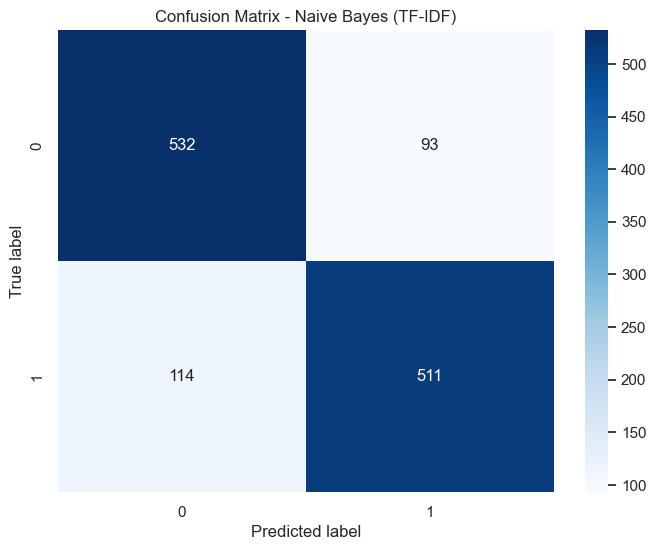

{'Accuracy': 0.8344,
 'Precision': 0.8460264900662252,
 'Recall': 0.8176,
 'F1-score': 0.8315703824247356}

In [12]:
# Compute confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Visualize confusion matrix as a heatmap
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes (TF-IDF)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Calculate performance metrics
metrics_nb = {
    "Accuracy":  accuracy_score(y_test, y_pred_nb),
    "Precision": precision_score(y_test, y_pred_nb),
    "Recall":    recall_score(y_test, y_pred_nb),
    "F1-score":  f1_score(y_test, y_pred_nb),
}

metrics_nb   # Display results

### **Interpretation of Naive Bayes Results (Baseline Model)**

The confusion matrix shows that the model performs well on both classes:
   - **True Negatives (TN) = 532**  
   - **False Positives (FP) = 93**  
   - **False Negatives (FN) = 114**  
   - **True Positives (TP) = 511**

Most errors fall into two categories:
   - **False Positives (93):** negative reviews predicted as positive  
   - **False Negatives (114):** positive reviews predicted as negative  

These errors are expected for a simple baseline model, but the results remain strong.

The performance metrics confirm this:
   - **Accuracy:** 83.44%  
   - **Precision:** 84.60%  
   - **Recall:** 81.76%  
   - **F1-score:** 83.16%  

Overall, the Naive Bayes model provides a **solid baseline** using TF-IDF features. It correctly classifies most reviews and shows balanced performance across both classes.

Next, we will investigate whether dimensionality reduction methods:
   - **SVD → Logistic Regression (Model 2)**  
   - **PCA → Logistic Regression (Model 3)**  

can improve accuracy, reduce false predictions, or create more robust representations in a lower-dimensional feature space.